# Part 3: Train a RetinaNet to Detect ElectroMagnetic Signals

**Author:** [lukewood](https://lukewood.xyz), Kevin Anderson, Peter Gerstoft<br>
**Date created:** 2022/08/16<br>
**Last modified:** 2022/08/16<br>
**Description:** Train ...

## Overview

With the learnings from part 2, lets take our newly tuned AnchorGenerator and fit another RetinaNet.
First, we will do all of the same setup that we did in the first tutorial.

In [25]:
import sys

import keras_cv
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import flags
from keras_cv import bounding_box
from tensorflow import keras
from tensorflow.keras import callbacks as callbacks_lib
from tensorflow.keras import optimizers
from luketils import artifacts
import em_loader
import wandb
from luketils import visualization
import os

batch_size = 8
epochs = 1

ground_truth_mapping = [
    "Ground Truth",
]
ground_truth_mapping = dict(zip(range(len(ground_truth_mapping)), ground_truth_mapping))

prediction_mapping = [
    "Prediction",
]
prediction_mapping = dict(zip(range(len(prediction_mapping)), prediction_mapping))

In [26]:
checkpoint_path = 'weights/'

In [27]:
artifacts_dir = 'artifacts/tuned-anchorbox'
artifacts.set_base(artifacts_dir)
os.makedirs(artifacts_dir, exist_ok=True)

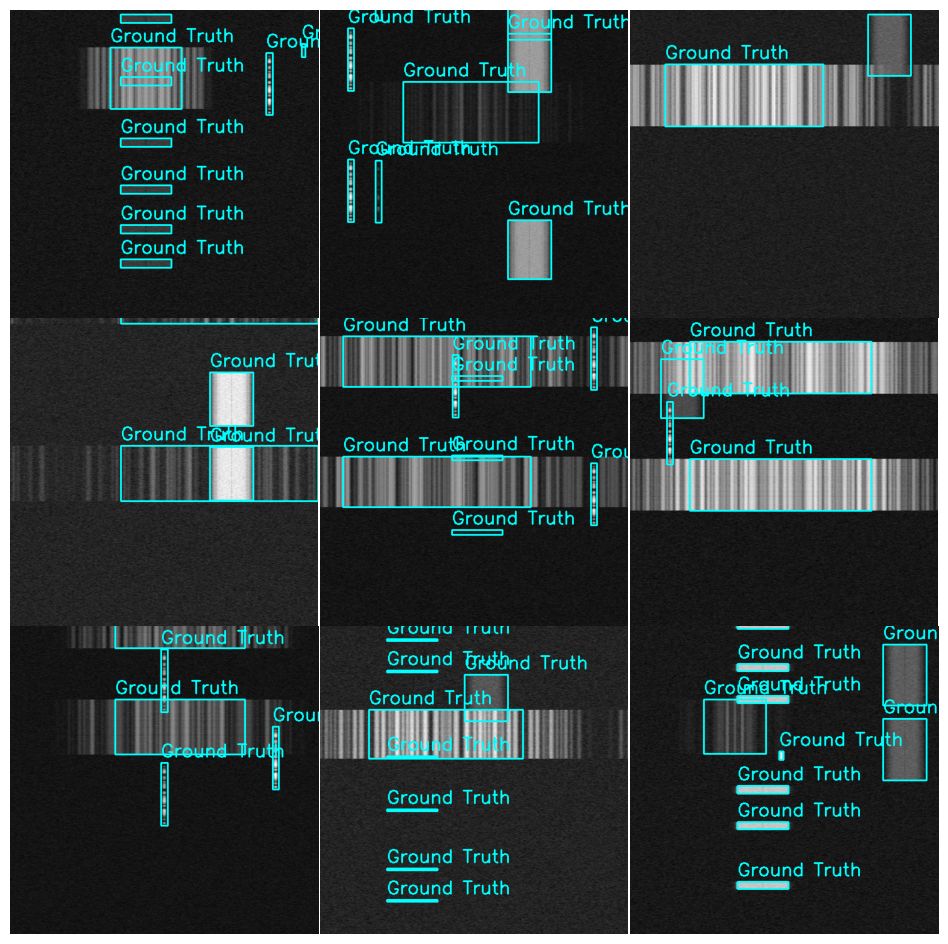

In [28]:
dataset, dataset_info = em_loader.load(
    split="train",
    bounding_box_format="xywh",
    batch_size=9,
    version=2,
)


example = next(iter(dataset))
images, boxes = example["images"], example["bounding_boxes"]
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_true=boxes,
    scale=4,
    rows=3,
    cols=3,
    thickness=2,
    font_scale=1,
    class_mapping=ground_truth_mapping,
    path=f"{artifacts_dir}/ground-truth.png",
)
visualization.plot_bounding_box_gallery(
    images,
    value_range=(0, 255),
    bounding_box_format="xywh",
    y_true=boxes,
    scale=4,
    rows=3,
    cols=3,
    thickness=2,
    font_scale=1,
    class_mapping=ground_truth_mapping,
    show=True,
)

Same as before, nothing to see here.

In [29]:
# train_ds is batched as a (images, bounding_boxes) tuple
# bounding_boxes are ragged
train_ds, train_dataset_info = em_loader.load(
    bounding_box_format="xywh", split="train", batch_size=batch_size, version=2
)
val_ds, val_dataset_info = em_loader.load(
    bounding_box_format="xywh", split="val", batch_size=batch_size, version=2
)


def unpackage_dict(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Our data pipeline is now complete.  We can now move on to model creation and training.

## Model creation

We'll use the KerasCV API to construct a RetinaNet model.  In this tutorial we use
a pretrained ResNet50 backbone using weights.  In order to perform fine-tuning, we
freeze the backbone before training.  When `include_rescaling=True` is set, inputs to
the model are expected to be in the range `[0, 255]`.

In [30]:
import tensorflow as tf
from tensorflow.keras import layers


class PredictionHead(layers.Layer):
    """The class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_initializer: Bias Initializer for the final convolution layer.

    Returns:
      A function representing either the classification
        or the box regression head depending on `output_filters`.
    """

    def __init__(self, output_filters, bias_initializer, num_conv_layers=3, **kwargs):
        super().__init__(**kwargs)
        self.output_filters = output_filters
        self.bias_initializer = bias_initializer
        self.num_conv_layers = num_conv_layers

        self.conv_layers = [
            layers.Conv2D(
                256,
                kernel_size=3,
                padding="same",
                kernel_initializer=tf.keras.initializers.Orthogonal(),
                activation="relu",
            )
            for _ in range(num_conv_layers)
        ]
        self.prediction_layer = layers.Conv2D(
            self.output_filters,
            kernel_size=3,
            strides=1,
            padding="same",
            kernel_initializer=tf.keras.initializers.Orthogonal(),
            bias_initializer=self.bias_initializer,
        )

    def call(self, x, training=False):
        for layer in self.conv_layers:
            x = layer(x, training=training)
        x = self.prediction_layer(x, training=training)
        return x

    def get_config(self):
        config = {
            "bias_initializer": self.bias_initializer,
            "output_filters": self.output_filters,
            "num_conv_layers": self.num_conv_layers,
        }
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [49]:
strides = [2**i for i in range(3, 8)]
scales = [2**x for x in [0, 1 / 3, 2 / 3]]
sizes = [32.0, 64.0, 128.0, 256.0, 512.0]
aspect_ratios=[0.098923504, 0.37597612, 0.8440275, 1.9752489, 3.036192, 9.539244]
anchor_generator = keras_cv.layers.AnchorGenerator(
    bounding_box_format='xywh',
    sizes=sizes,
    aspect_ratios=aspect_ratios,
    scales=scales,
    strides=strides,
    clip_boxes=True,
)

In [51]:
import numpy as np
prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
classification_head = PredictionHead(
    output_filters=18 * 1, bias_initializer=prior_probability
)
box_head = PredictionHead(
    output_filters=18 * 4, bias_initializer="zeros"
)

In [53]:
model = keras_cv.models.RetinaNet(
    classes=1,
    anchor_generator=anchor_generator,
    bounding_box_format="xywh",
    backbone="resnet50",
    backbone_weights="imagenet",
    classification_head = classification_head,
    box_head = box_head,
    include_rescaling=True,
    evaluate_train_time_metrics=False,
)

In [54]:
optimizer = tf.optimizers.SGD(global_clipnorm=10.0)
metrics = [
    keras_cv.metrics.COCOMeanAveragePrecision(
        class_ids=range(1),
        bounding_box_format="xywh",
        name="MaP",
    ),
    keras_cv.metrics.COCORecall(
        class_ids=range(1),
        bounding_box_format="xywh",
        max_detections=100,
        name="Recall",
    ),
]

model.compile(
    classification_loss=keras_cv.losses.FocalLoss(from_logits=True, reduction="none"),
    box_loss=keras_cv.losses.SmoothL1Loss(l1_cutoff=1.0, reduction="none"),
    optimizer=optimizer,
    metrics=metrics,
)

All that is left to do is construct some callbacks:

In [55]:
callbacks = [
    callbacks_lib.TensorBoard(log_dir="logs"),
    callbacks_lib.EarlyStopping(patience=20),
    callbacks_lib.ReduceLROnPlateau(patience=10),
    keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True),
]

And run `model.fit()`!

In [56]:
history = model.fit(
    train_ds,
    validation_data=val_ds.take(20),
    epochs=200,
    callbacks=callbacks,
)

Epoch 1/200
483/483 [==============================] - 84s 159ms/step - loss: 3.6351 - classification_loss: 1.5748 - regularization_loss: 0.0000e+00 - box_loss: 2.0602 - val_MaP: 0.2301 - val_Recall: 0.3744 - val_loss: 2.0258 - val_classification_loss: 0.8449 - val_box_loss: 1.1809 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 2/200
483/483 [==============================] - 72s 148ms/step - loss: 1.2094 - classification_loss: 0.4106 - regularization_loss: 0.0000e+00 - box_loss: 0.7988 - val_MaP: 0.3167 - val_Recall: 0.4174 - val_loss: 1.1552 - val_classification_loss: 0.4641 - val_box_loss: 0.6911 - val_regularization_loss: 0.0000e+00 - lr: 0.0100
Epoch 3/200
483/483 [==============================] - 73s 150ms/step - loss: 0.7538 - classification_loss: 0.2140 - regularization_loss: 0.0000e+00 - box_loss: 0.5398 - val_MaP: 0.3351 - val_Recall: 0.4511 - val_loss: 0.8410 - val_classification_loss: 0.2887 - val_box_loss: 0.5523 - val_regularization_loss: 0.0000e+00 - lr: 0.010

In [57]:
metrics = history.history

In [58]:
', '.join(metrics.keys())

'loss, classification_loss, regularization_loss, box_loss, val_MaP, val_Recall, val_loss, val_classification_loss, val_box_loss, val_regularization_loss, lr'

In [59]:
import matplotlib.pyplot as plt


def line_plot(
    data,
    title=None,
    legend=None,
    xlabel=None,
    ylabel=None,
    show=None,
    path=None,
    transparent=True,
    dpi=60,
    palette="mako_r",
):
    """Produces a line plot based on a dictionary of metrics and labels."""
    import seaborn as sns

    if show and path is not None:
        raise ValueError("Expected either `show` or `path` to be set, but not both.")
    if path is None and show is None:
        show = True
    palette = sns.color_palette("mako_r", len(data.keys()))

    sns.lineplot(data=data, palette=palette)
    plt.legend(list(data.keys()))

    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)

    plt.suptitle(title)

    if path is None and not show:
        return
    if path is not None:
        plt.savefig(
            fname=path,
            pad_inches=0,
            bbox_inches="tight",
            transparent=transparent,
            dpi=dpi,
        )
        plt.close()
    elif show:
        plt.show()
        plt.close()
import keras_cv
from luketils import utils
from luketils import drawing
from luketils.visualization.plot_gallery import plot_gallery
import functools


def plot_bounding_box_gallery(
    images,
    value_range,
    bounding_box_format,
    pred_color=(255, 128, 0),
    true_color=(0, 255, 255),
    y_true=None,
    y_pred=None,
    thickness=2,
    font_scale=1.0,
    text_thickness=None,
    class_mapping=None,
    ground_truth_mapping=None,
    prediction_mapping=None,
    **kwargs
):
    """plots a gallery of images with corresponding bounding box annotations

    !Example bounding box gallery](https://i.imgur.com/Fy7kMnP.png)

    Args:
        images: a Tensor or NumPy array containing images to show in the gallery.
        value_range: value range of the images.
        bounding_box_format: the bounding_box_format  the provided bounding boxes are
            in.
        y_true: a Tensor or RaggedTensor representing the ground truth bounding boxes.
        y_pred: a Tensor or RaggedTensor representing the predicted truth bounding
            boxes.
        pred_color: three element tuple representing the color to use for plotting
            predicted bounding boxes.
        true_color: three element tuple representing the color to use for plotting
            true bounding boxes.
        class_mapping: (Optional) class mapping from class IDs to strings
        ground_truth_mapping:  (Optional) class mapping from class IDs to strings,
            defaults to `class_mapping`
        prediction_mapping:  (Optional) class mapping from class IDs to strings,
            defaults to `class_mapping`
        thickness: (Optional) thickness for the box and text labels.  Defaults to 2.
        text_thickness: (Optional) the thickness for the text, defaults to `1.0`.
        font_scale: (Optional) font size to draw bounding boxes in.
        kwargs: keyword arguments to propagate to
            `keras_cv.visualization.gallery_show()`.
    """
    prediction_mapping = prediction_mapping or class_mapping
    ground_truth_mapping = ground_truth_mapping or class_mapping

    images = utils.to_numpy(images)
    y_true = utils.to_numpy(y_true)

    plotted_images = images

    draw_fn = functools.partial(
        drawing.draw_bounding_boxes,
        bounding_box_format=bounding_box_format,
        thickness=thickness,
        text_thickness=text_thickness,
        font_scale=font_scale,
    )

    if y_true is not None:
        plotted_images = draw_fn(
            plotted_images, y_true, true_color, class_mapping=ground_truth_mapping
        )

    if y_pred is not None:
        plotted_images = draw_fn(
            plotted_images, y_pred, pred_color, class_mapping=prediction_mapping
        )

    plot_gallery(plotted_images, value_range, **kwargs)

visualization.plot_bounding_box_gallery = plot_bounding_box_gallery
visualization.line_plot = line_plot

In [73]:
metrics_to_plot = {
    'Train': metrics['loss'],
    'Validation': metrics['val_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Loss', xlabel='Epochs', ylabel='Loss', transparent=True)
plot_fn(path=f'{artifacts_dir}/loss.png')
plot_fn(show=True)

KeyError: 'val_loss'

In [ ]:
metrics_to_plot = {
    'Mean Average Precision': metrics['val_MaP'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Mean Average Precision', xlabel='Epochs', ylabel='Mean Average Precision')
plot_fn(path=f'{artifacts_dir}/MaP.png')
plot_fn(show=True)


In [ ]:
metrics_to_plot = {
    'Recall': metrics['val_Recall'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Recall', xlabel='Epochs', ylabel='Recall')
plot_fn(path=f'{artifacts_dir}/Recall.png')
plot_fn(show=True)

In [ ]:
metrics_to_plot = {
    'Train': metrics['box_loss'],
    'Validation': metrics['val_box_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='Box Loss', xlabel='Epochs', ylabel='Box Loss')
plot_fn(path=f'{artifacts_dir}/box_loss.png')
plot_fn(show=True)

In [ ]:
metrics_to_plot = {
    'Train': metrics['classification_loss'],
    'Validation': metrics['val_classification_loss'],
}

plot_fn = functools.partial(line_plot, data=metrics_to_plot, title='Classification Loss', xlabel='Epochs', ylabel='Classification Loss')
plot_fn(path=f'{artifacts_dir}/classification_loss.png')
plot_fn(show=True)

In [ ]:
metrics_to_plot = {
    'Train Box Loss': metrics['box_loss'],
    'Validation Box Loss': metrics['val_box_loss'],
    'Train Classification Loss': metrics['classification_loss'],
    'Validation Classification Loss': metrics['val_classification_loss'],
}

plot_fn = functools.partial(visualization.line_plot, data=metrics_to_plot, title='All Losses', xlabel='Epochs', ylabel='Box Loss')
plot_fn(path=f'{artifacts_dir}/all_losses.png')
plot_fn(show=True)

In [74]:
model.load_weights(checkpoint_path)

In [75]:
metrics = model.evaluate(val_ds, return_dict=True)

104/104 [==============================] - 105s 999ms/step - MaP: 0.5102 - Recall: 0.5711 - loss: 0.5210 - classification_loss: 0.3043 - box_loss: 0.2167 - regularization_loss: 0.0000e+00


In [76]:
print("FINAL METRICS:", metrics)

FINAL METRICS: {'MaP': 0.5102368593215942, 'Recall': 0.5710644125938416, 'loss': 0.5209680199623108, 'classification_loss': 0.3042832612991333, 'box_loss': 0.2166847139596939, 'regularization_loss': 0.0}


In [77]:
os.makedirs(f'{artifacts_dir}/metrics/', exist_ok=True)
for metric in metrics:
    with open(f"{artifacts_dir}/metrics/{metric}.txt", "w") as f:
        f.write(str(metrics[metric]))

In [78]:
import functools

def visualize_detections(model, split="train"):
    train_ds, val_dataset_info = em_loader.load(
        bounding_box_format="xywh", split=split, batch_size=9
    )
    train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
    images, y_true = next(iter(train_ds.take(1)))
    y_pred = model.predict(images)
    
    plot_fn = functools.partial(
        visualization.plot_bounding_box_gallery,
        images,
        value_range=(0, 255),
        bounding_box_format='xywh',
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=3,
        cols=3,
        thickness=2,
        font_scale=1,
        ground_truth_mapping=ground_truth_mapping,
        prediction_mapping=prediction_mapping,
    )
    plot_fn(
        show=True,
    )
    plot_fn(
        path=f"{artifacts_dir}/{split}.png"
    )
    

1/1 [==============================] - 0s 68ms/step


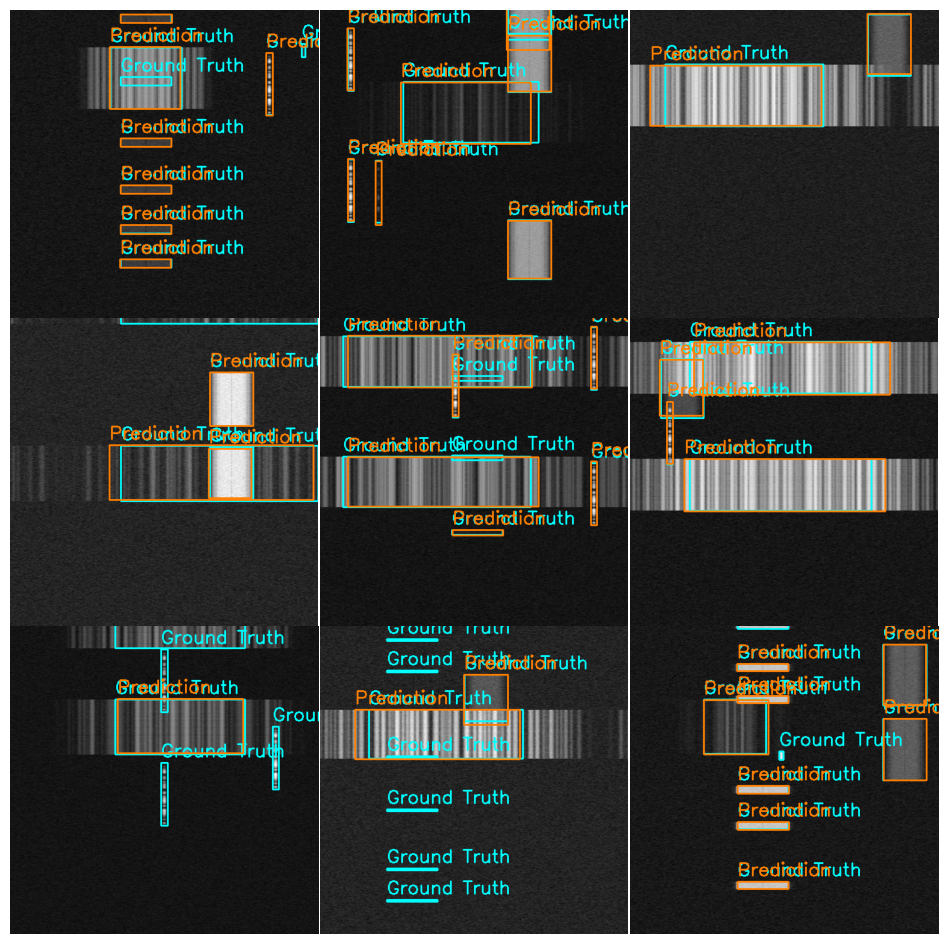

In [79]:
visualize_detections(model, split="train")

1/1 [==============================] - 0s 69ms/step


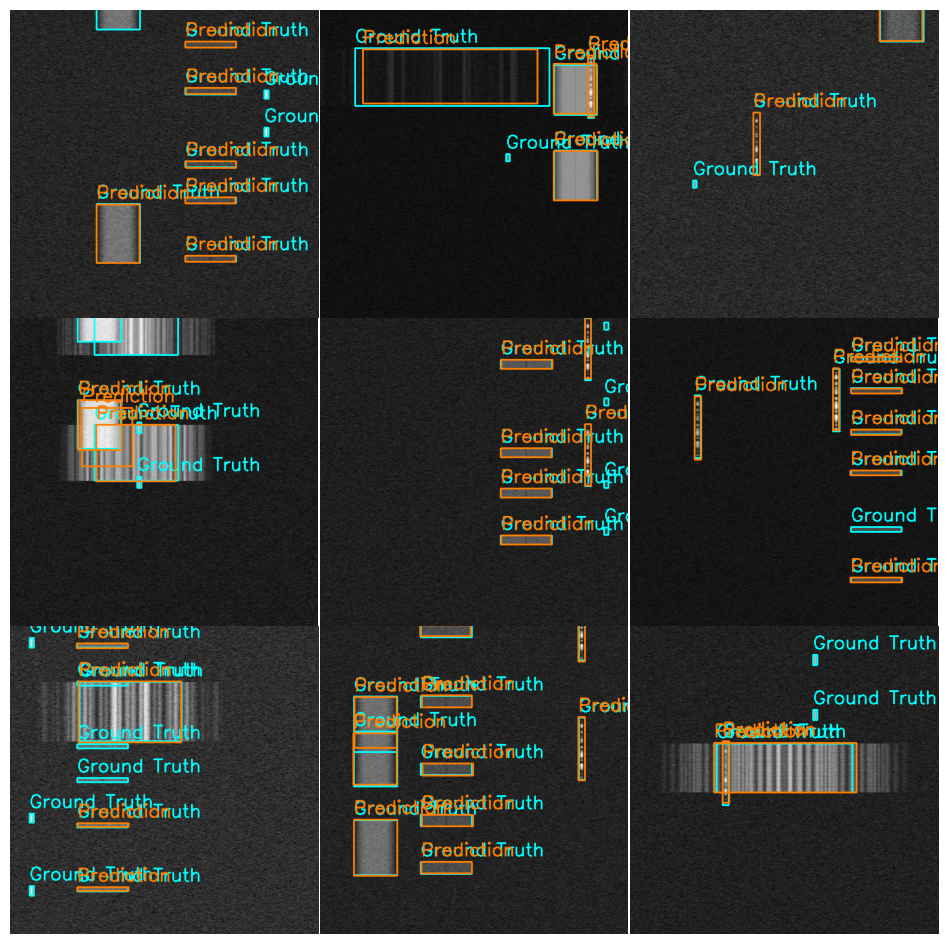

In [80]:
visualize_detections(model, split="val")